# Import Statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import healpy as hp
import astropy
from astropy.time import Time
from datetime import datetime
import time
import scipy
from scipy.stats import linregress
import math
import csv

# Files for Rates and Weather

In [2]:
rates_path = '/home/rykore/rates/'
weather_path = '/home/rykore/weather/'

In [3]:
rates_file_name = sorted(os.listdir(rates_path))
rates_file = []
for file_name in rates_file_name:
    rates_file.append(rates_path + file_name)
print(rates_file)

['/home/rykore/rates/hawc-rates_2015.txt', '/home/rykore/rates/hawc-rates_2016.txt', '/home/rykore/rates/hawc-rates_2017.txt', '/home/rykore/rates/hawc-rates_2018.txt', '/home/rykore/rates/hawc-rates_2019.txt', '/home/rykore/rates/hawc-rates_2020.txt', '/home/rykore/rates/hawc-rates_2021.txt', '/home/rykore/rates/hawc-rates_2022.txt', '/home/rykore/rates/hawc-rates_2023.txt']


In [4]:
weather_file_name = sorted(os.listdir(weather_path))
weather_file =[]
for file_name in weather_file_name:
    weather_file.append(weather_path + file_name)

print(weather_file)

['/home/rykore/weather/hawc-weather-2012.txt', '/home/rykore/weather/hawc-weather-2013.txt', '/home/rykore/weather/hawc-weather-2014.txt', '/home/rykore/weather/hawc-weather-2015.txt', '/home/rykore/weather/hawc-weather-2016.txt', '/home/rykore/weather/hawc-weather-2017.txt', '/home/rykore/weather/hawc-weather-2018.txt', '/home/rykore/weather/hawc-weather-2019.txt', '/home/rykore/weather/hawc-weather-2020.txt', '/home/rykore/weather/hawc-weather-2021.txt', '/home/rykore/weather/hawc-weather-2022.txt']


In [5]:
def get_common_paths(rates_file, weather_file):
    
    rates_years = {file.split('_')[-1][:4]: file for file in rates_file}
    weather_years = {file.split('-')[-1][:4]: file for file in weather_file}

    common_years = sorted(rates_years.keys() & weather_years.keys())

    rates_file_path = [rates_years[year] for year in common_years]
    weather_file_path = [weather_years[year] for year in common_years]

    return rates_file_path, weather_file_path, common_years


In [6]:
rates_file_path , weather_file_path, years = get_common_paths(rates_file, weather_file)
print(rates_file_path)
print(weather_file_path)
print(len(rates_file_path))
print(len(weather_file_path))
print(years)

['/home/rykore/rates/hawc-rates_2015.txt', '/home/rykore/rates/hawc-rates_2016.txt', '/home/rykore/rates/hawc-rates_2017.txt', '/home/rykore/rates/hawc-rates_2018.txt', '/home/rykore/rates/hawc-rates_2019.txt', '/home/rykore/rates/hawc-rates_2020.txt', '/home/rykore/rates/hawc-rates_2021.txt', '/home/rykore/rates/hawc-rates_2022.txt']
['/home/rykore/weather/hawc-weather-2015.txt', '/home/rykore/weather/hawc-weather-2016.txt', '/home/rykore/weather/hawc-weather-2017.txt', '/home/rykore/weather/hawc-weather-2018.txt', '/home/rykore/weather/hawc-weather-2019.txt', '/home/rykore/weather/hawc-weather-2020.txt', '/home/rykore/weather/hawc-weather-2021.txt', '/home/rykore/weather/hawc-weather-2022.txt']
8
8
['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']


# Convert_file function

In [7]:
def convert_file(file_path):
    if 'rates' in file_path:
        df = pd.read_csv(file_path, delim_whitespace=True, usecols=[1, 2, 3, 4], header=None, skiprows=1)
        df.columns = ['Date', 'Time', 'Rate', 'LivePMTs']
        df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

        # Filter out rows with NaT in 'DateTime'
        df = df.dropna(subset=['DateTime'])

        df = df[df['LivePMTs'] != 0]

        # Convert the 'DateTime' column to an array of 'datetime.datetime' objects
        datetime_objects = df['DateTime'].dt.to_pydatetime()

        # Convert DateTime to MJD
        mjd_values = Time(datetime_objects, format='datetime', scale='utc').mjd

        # Convert Rate and LivePMTs to float
        rates = df['Rate'].astype(float).to_numpy()
        livepmts = df['LivePMTs'].astype(float).to_numpy()

        return mjd_values, rates, livepmts

    elif 'weather' in file_path:
        df = pd.read_csv(file_path, delim_whitespace=True, usecols=[0, 1, 2, 3, 4, 5], header=None, skiprows=9)
        df.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Pressure']

        # Combine Year, Month, Day, Hour, and Minute into a single DateTime column and parse
        df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).agg('-'.join, axis=1), 
                                        format='%Y-%m-%d-%H-%M', errors='coerce')

        # Filter out rows with NaT in 'DateTime'
        df = df.dropna(subset=['DateTime'])

        # Convert the 'DateTime' column to an array of 'datetime.datetime' objects
        datetime_objects_weather = df['DateTime'].dt.to_pydatetime()

        # Convert DateTime to MJD
        mjd_values_weather = Time(datetime_objects_weather, format='datetime', scale='utc').mjd

        # Convert Pressure to float
        pressure_total = df['Pressure'].astype(float).to_numpy()

        return mjd_values_weather, pressure_total


# Converting rates and weather files to plot them

In [8]:
rates_data = {}
weather_data = {}
years = {}

start = time.time()


#checking if the for loop is parsing through corresponding elements in the two sequences
for rates_path, weather_path in zip(rates_file_path, weather_file_path):
    
    year = rates_path.split('_')[-1].split('.')[0]
    
    mjd_time_rates, rates, livepmts = convert_file(rates_path)
    rates_over_pmt = rates/livepmts
    rates_modified = rates/1e3
    rates_data[year] = {'mjd_time_rates': mjd_time_rates, 'rates': rates, 'rates_modified': rates_modified, 'rates_over_pmt': rates_over_pmt}

    mjd_time_weather, pressure = convert_file(weather_path)
    weather_data[year] = {'mjd_time_weather': mjd_time_weather, 'pressure': pressure}

end = time.time()

print(end-start, "seconds")

57.012615442276 seconds


In [9]:
print(rates_data['2019']['mjd_time_rates'][:5])
print(weather_data['2019']['mjd_time_weather'][:5])

[58483.75315394 58483.75604745 58483.75749421 58483.75894097
 58483.76038773]
[58484.         58484.00069444 58484.00138889 58484.00208333
 58484.00277778]


In [10]:
print(rates_data['2021']['rates_modified'][:5])
print(weather_data['2021']['pressure'][:5])

[24.699552 24.71428  24.711808 24.682512 24.688296]
[622.075 622.238 622.238 622.238 622.238]


# Plotting the graphs - make_plot() fucntion

In [11]:
def make_plot(year, weather_lower_y = 0 , weather_upper_y = 0 , rates_lower_y = 0, rates_upper_y = 0, make_plot = False):

    xmin = min(weather_data[year]['mjd_time_weather'])
    xmax = max(weather_data[year]['mjd_time_weather'])

    if make_plot == True:

        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        ax1.plot(weather_data[year]['mjd_time_weather'], weather_data[year]['pressure'], ".", label='Pressure', color='blue')
        ax1.set_ylim(weather_lower_y, weather_upper_y)
        # ax1.set_xlim(0, xmax - xmin)
        
        ax1.set_xlabel('MJD-%s' % xmin, fontsize=18)
        ax1.set_ylabel('Pressure (mbar)', fontsize=20, color='blue')
        ax1.tick_params('y', colors='blue')
        ax1.legend(loc='lower left', numpoints=1, fontsize=18)
        ax1.grid(True)
        
        for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
            item.set_fontsize(18)
        
        ax2 = ax1.twinx()
    
        # Plot rate data on secondary y-axis (ax2)
        # ax2.plot(mjd_time_rates, rates, ".", label='Rate', color='red')
        ax2.plot(rates_data[year]['mjd_time_rates'], rates_data[year]['rates_over_pmt'], ".", label='Rate over pmts', color='red')
        ax2.set_ylim(rates_lower_y,rates_upper_y)
    
        ax2.set_ylabel('Data Rate (Hz)', fontsize=20, color='red')
        ax2.tick_params('y', colors='red')
        ax2.legend(loc='lower right', numpoints=1, fontsize=18)
        
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(18)
        
        # Title
        plt.title('HAWC Atmospheric Pressure - {0}'.format(year), fontsize=17)
        
        fig.tight_layout()
        
        plt.show()

    if make_plot == False:

        return xmin, xmax

## Year 2015

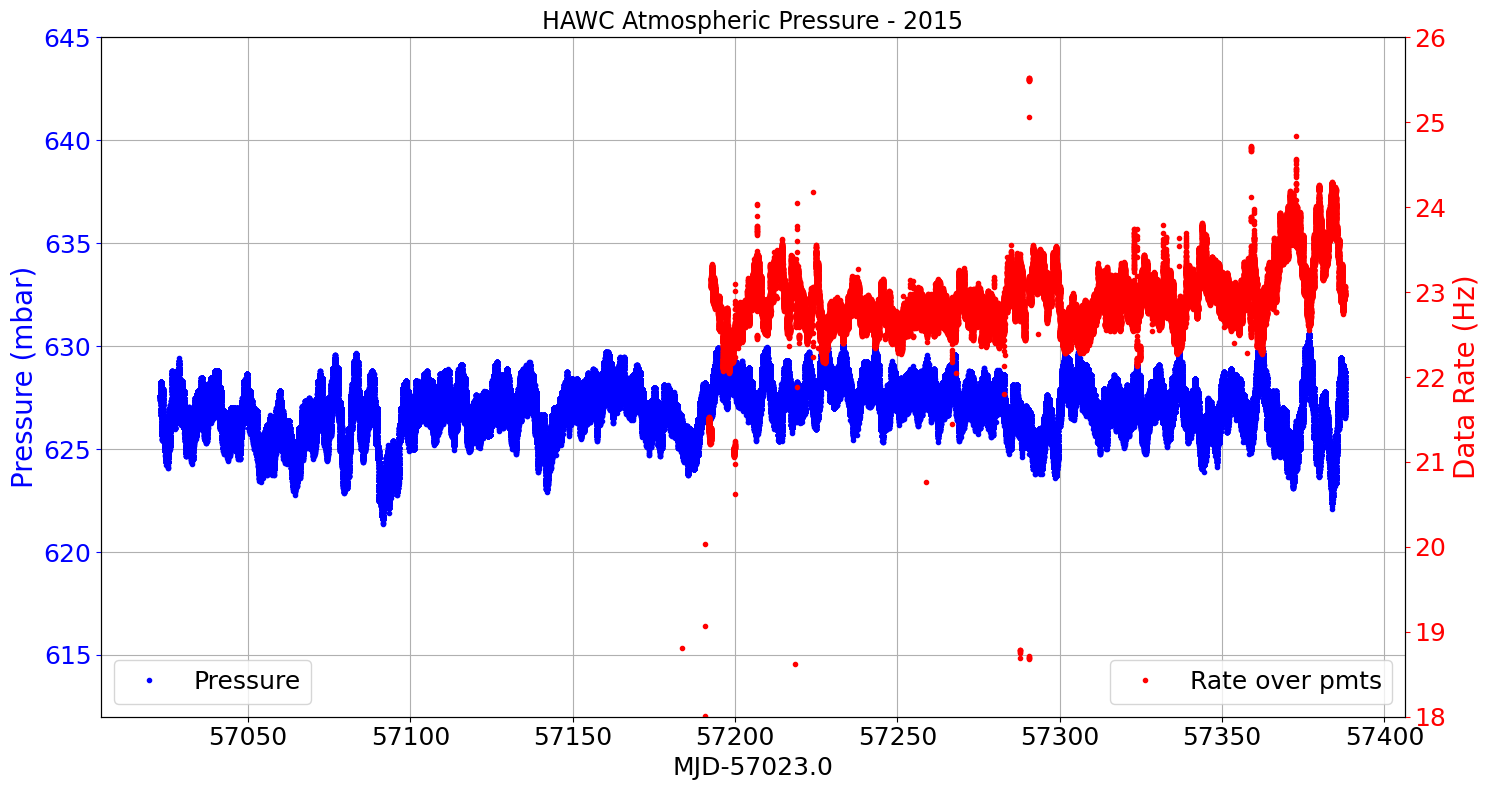

In [12]:
make_plot('2015',612,645,18,26,True)

## Year 2016

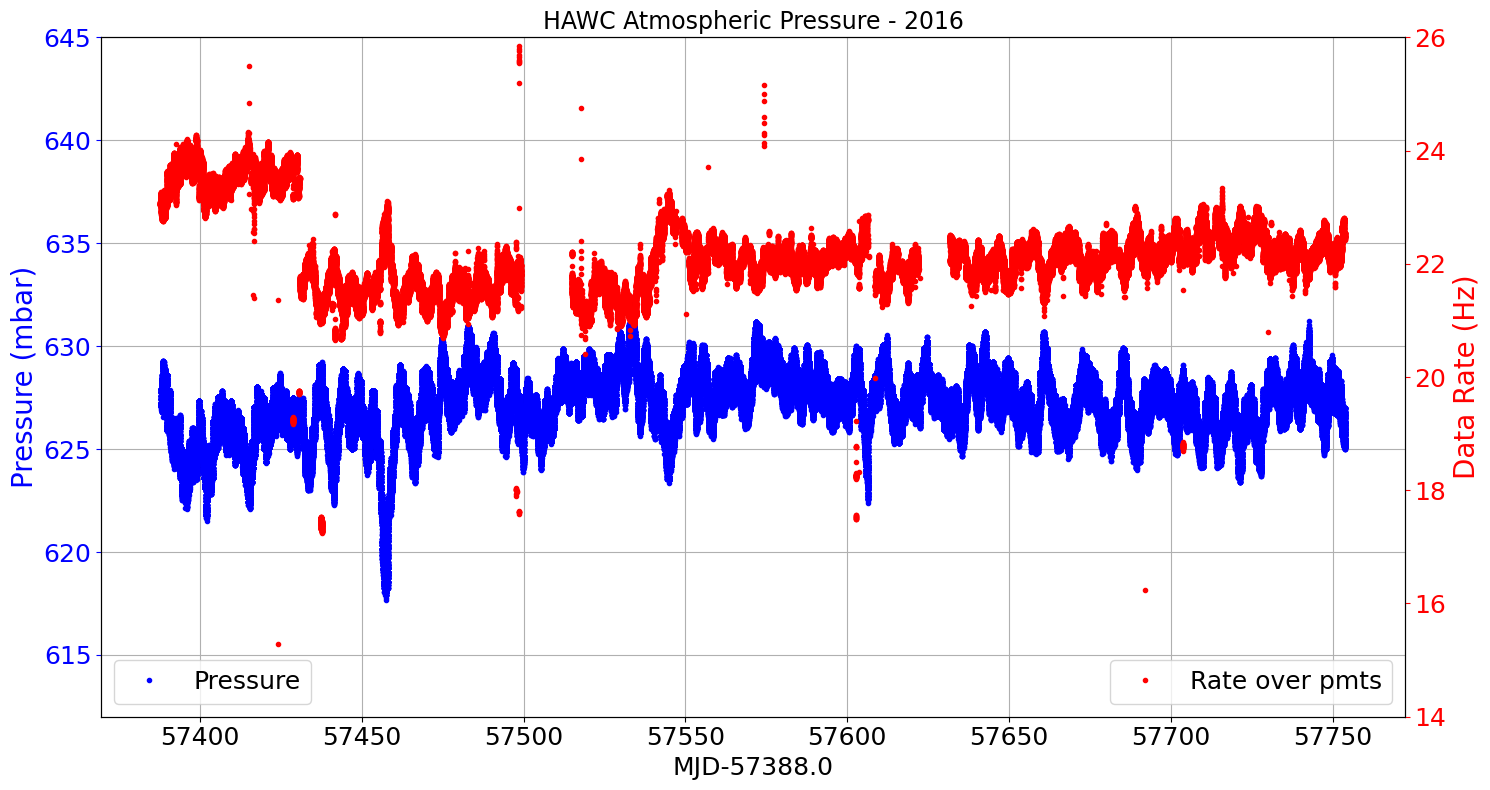

In [13]:
make_plot('2016',612,645,14,26,make_plot = True)

## Year 2017

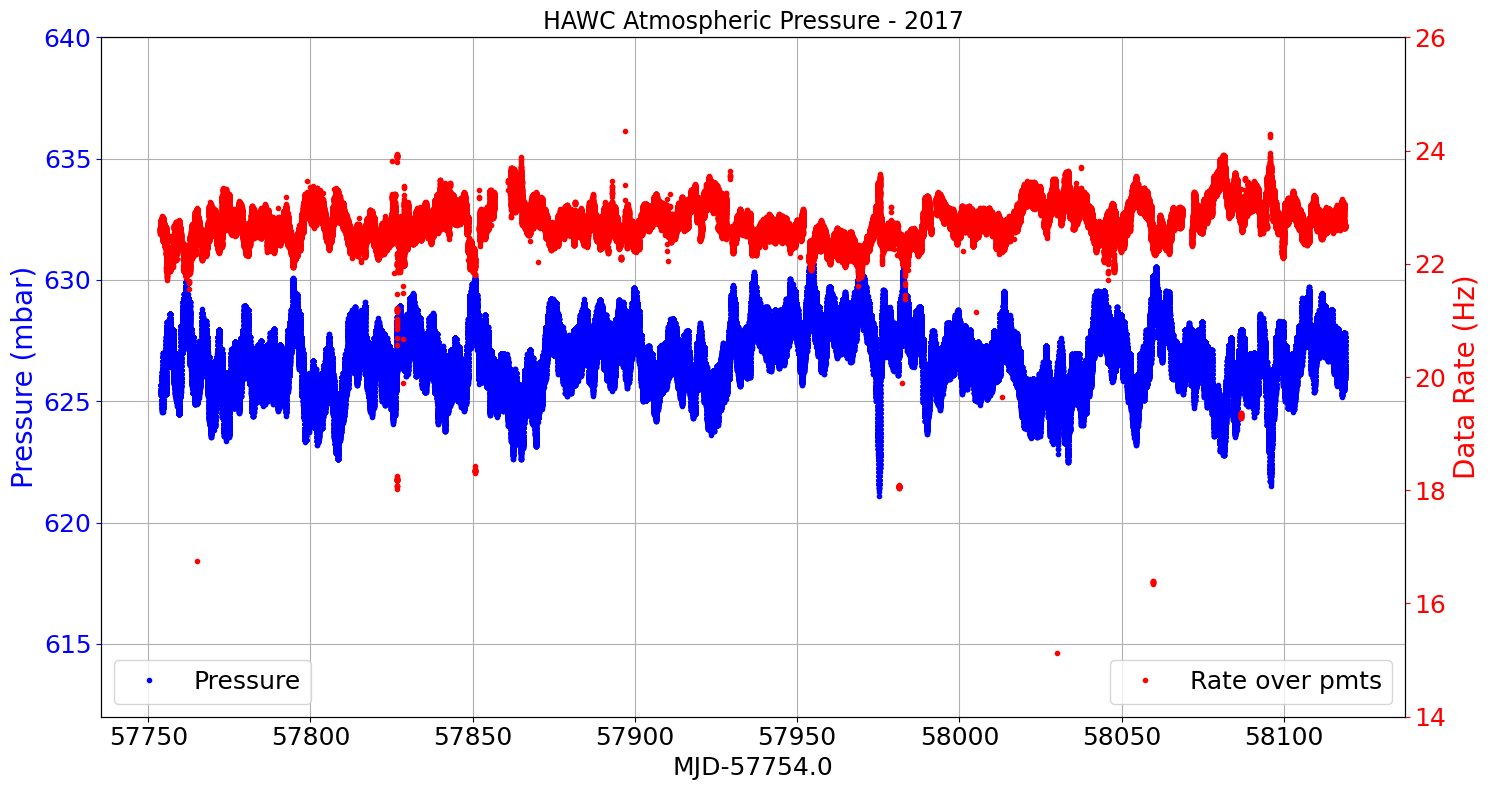

In [14]:
make_plot('2017',612,640,14,26,make_plot = True)

## Year 2018

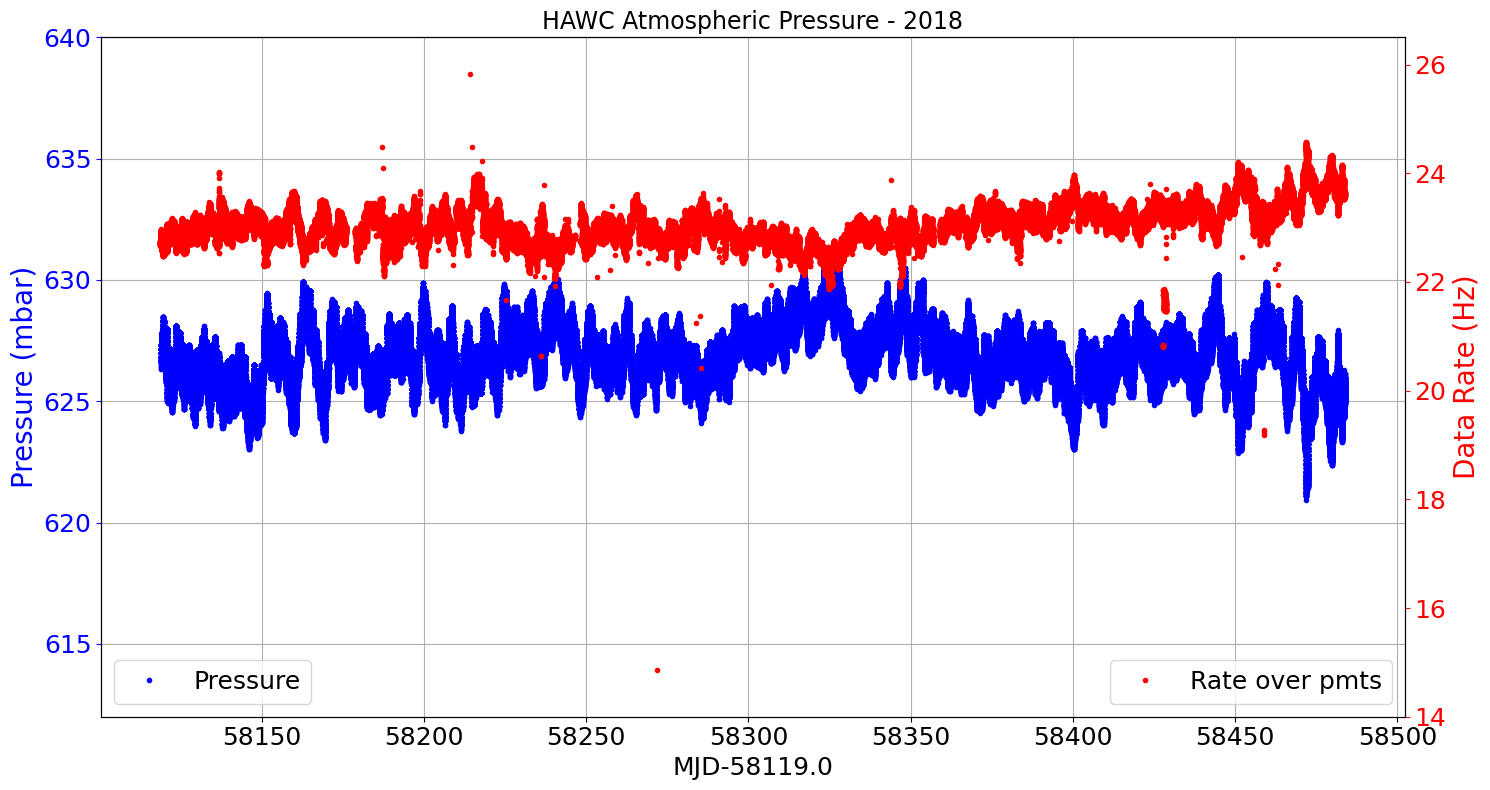

In [15]:
make_plot('2018',612,640,14,26.5,make_plot = True)

## Year 2019

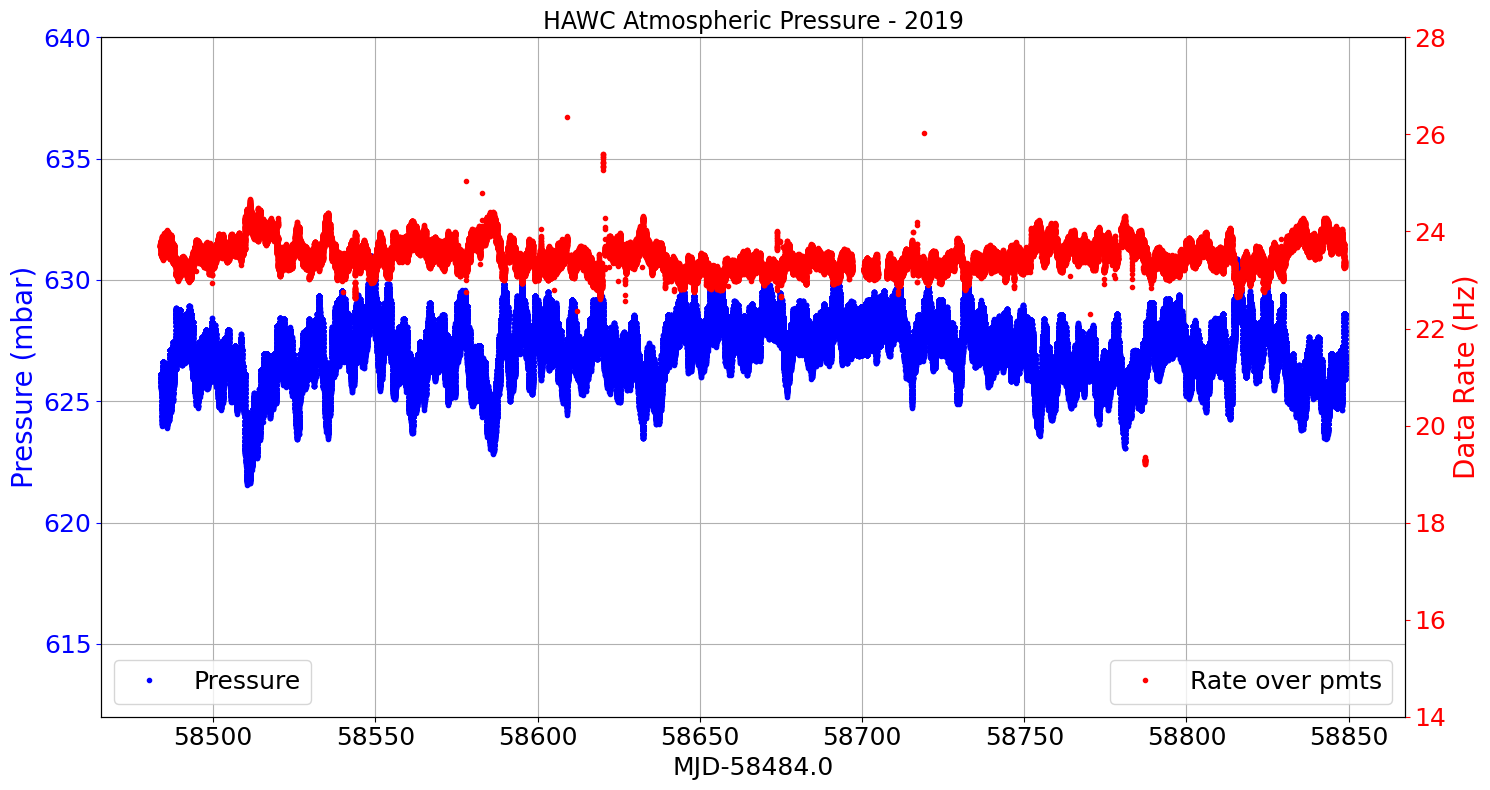

In [16]:
make_plot('2019',612,640,14,28,make_plot = True)

## Year 2020

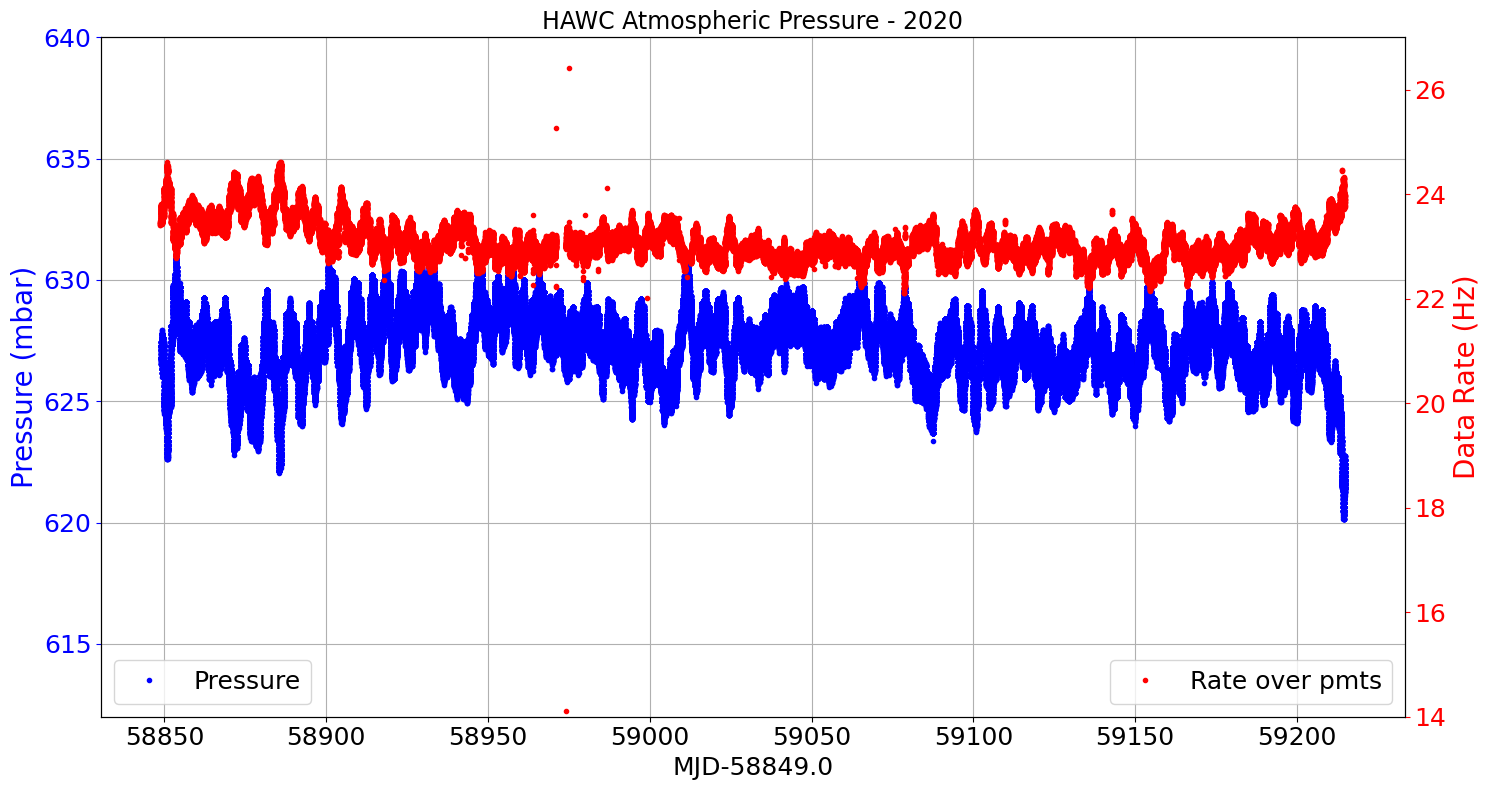

In [17]:
make_plot('2020',612,640,14,27,make_plot = True)

## Year 2021

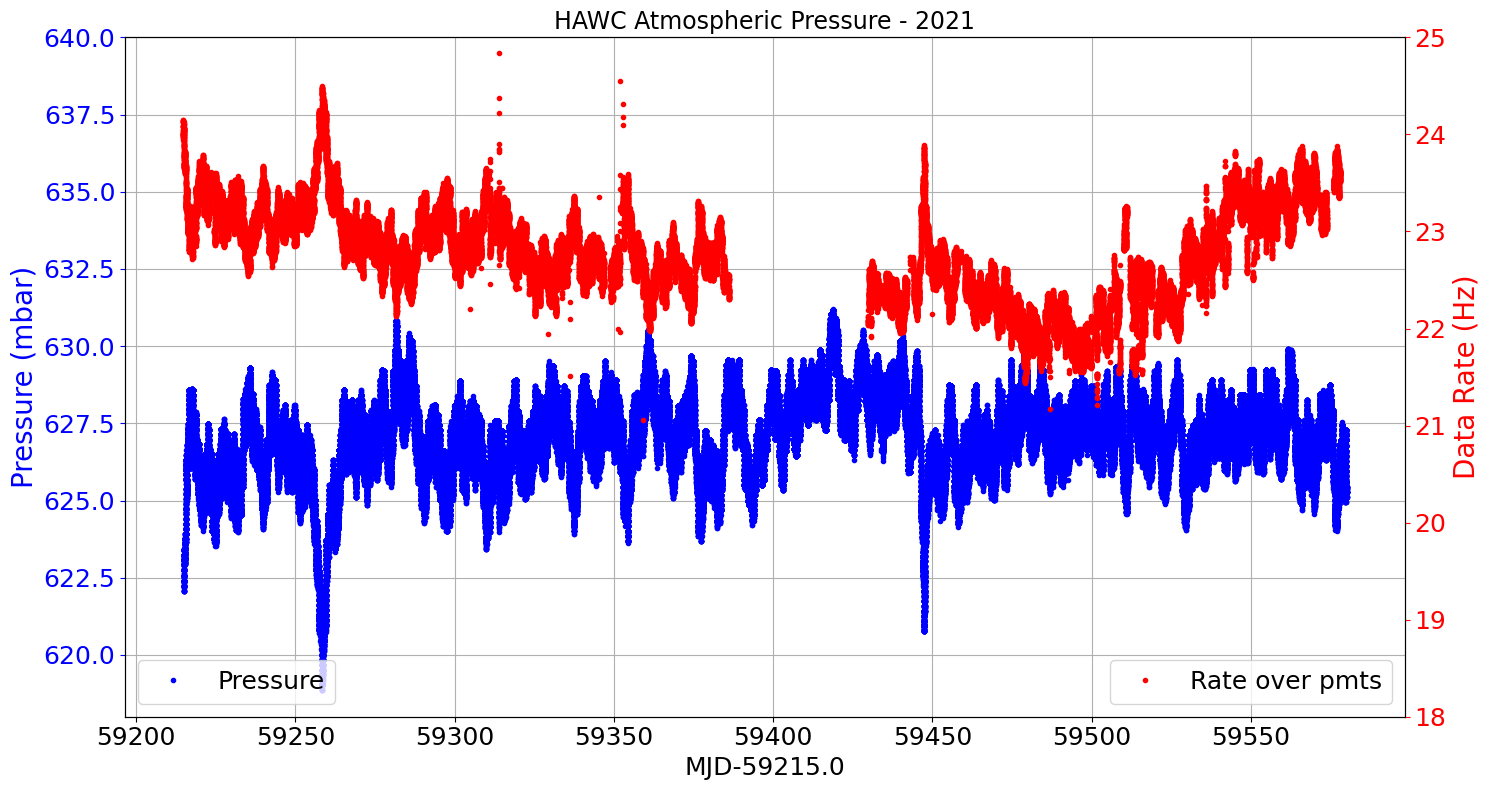

In [18]:
make_plot('2021',618,640,18,25,make_plot = True)

## Year 2022

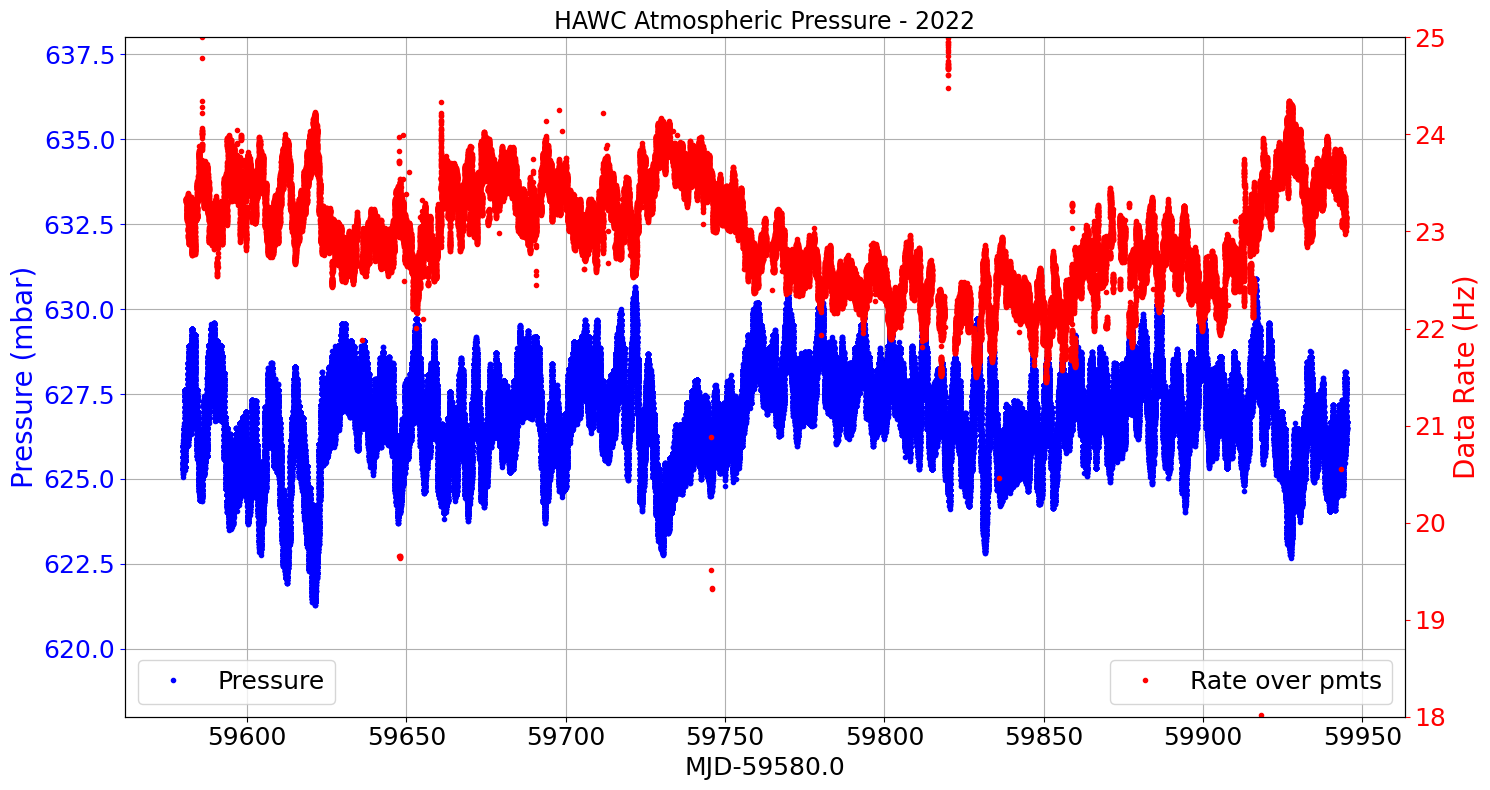

In [19]:
make_plot('2022',618,638,18,25,make_plot = True)

# Finding the Correlation coefficient - correlation_coeff() function

In [20]:
# xmax - xmin = time range
# delta_t = 8 mins in units of days
# no of bins = int(time_range/delta_t)

In [37]:
def correlation_coeff(year):
    
    xmin , xmax = make_plot(year, make_plot = False)
    time_range = xmax - xmin
    delta = 5.55e-03  # this is 8 mins in units of days
    bins = int(time_range/delta)

    avg_pressure, bin_edges_pressure = np.histogram(weather_data[year]['mjd_time_weather'], bins = bins, weights = weather_data[year]['pressure'])
    avg_time_weather, bin_edges_time_weather = np.histogram(weather_data[year]['mjd_time_weather'], bins = bins, weights = None)

    avg_pressure_per_time_interval = avg_pressure/avg_time_weather

    avg_rates, bin_edges_rates = np.histogram(rates_data[year]['mjd_time_rates'], bins = bins, weights = rates_data[year]['rates_modified'])
    avg_time_rates, bin_edges_time_rates = np.histogram(rates_data[year]['mjd_time_rates'], bins = bins, weights = None)

    avg_rates_per_time_interval = avg_rates / avg_time_rates
    zero_mask = (avg_time_rates == 0)
    avg_rates_per_time_interval[zero_mask] = np.nan

    # Your x and y data, replace these with your actual data arrays
    x_data = avg_pressure_per_time_interval
    y_data = avg_rates_per_time_interval

    # Remove NaN values from your data for regression
    mask = (~np.isnan(x_data) & ~np.isnan(y_data))
    x_data_clean = x_data[mask]
    y_data_clean = y_data[mask]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, y_data_clean)
    
    # Generate y-values for the fit line over the range of x_data
    fit_line = slope * x_data_clean + intercept
    
    # Plotting the original data
    plt.figure(figsize=(8, 6))
    plt.plot(x_data, y_data, '.', label='Original data')
    
    # Plotting the fit line
    # Make sure to sort x_data_clean for a proper line plot
    sorted_indices = np.argsort(x_data_clean)
    plt.plot(x_data_clean[sorted_indices], fit_line[sorted_indices], 'r', label='Fitted line')
    
    # Adding labels and legend
    plt.xlabel('Average Pressure Per Time Interval')
    plt.ylabel('Average Rates Per Time Interval')
    plt.title('Linear Fit to Data')
    plt.legend()
    
    # Display the plot
    plt.show()
    
    print(slope)

/tmp/ipykernel_341/3863555752.py:16: RuntimeWarning: invalid value encountered in divide
  avg_rates_per_time_interval = avg_rates / avg_time_rates


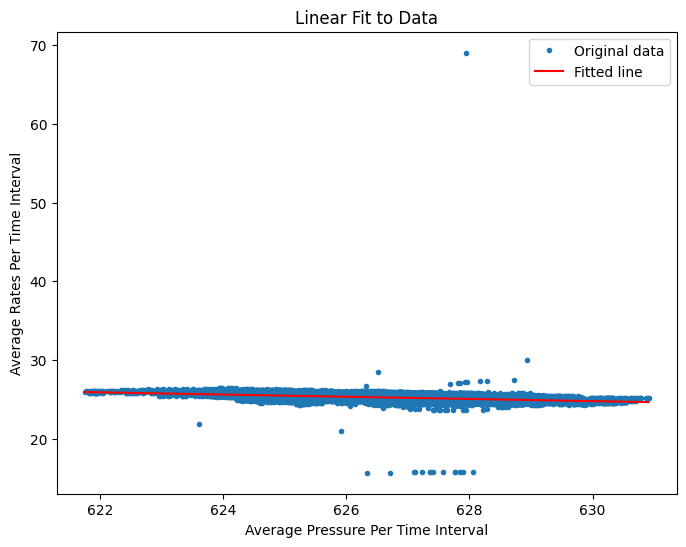

-0.13983118791960011


In [38]:
correlation_coeff('2019')

/tmp/ipykernel_341/3863555752.py:16: RuntimeWarning: invalid value encountered in divide
  avg_rates_per_time_interval = avg_rates / avg_time_rates


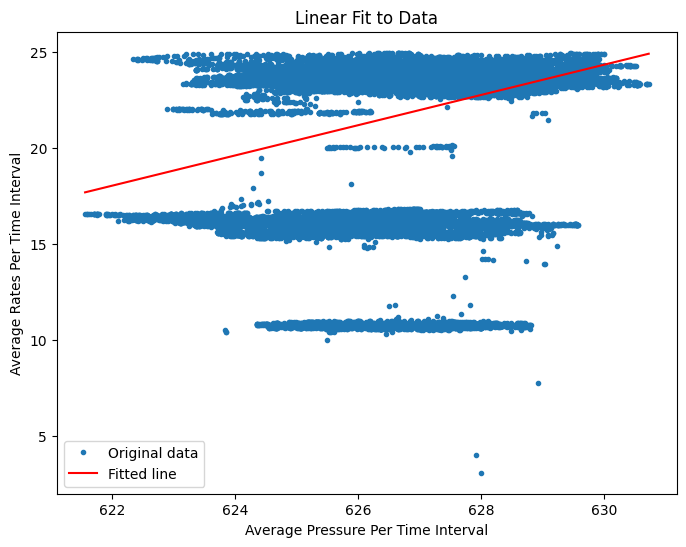

0.7857970837900633


In [39]:
correlation_coeff('2015')